In [1]:
import logging

# 设置关键库的日志级别
loggers_to_quiet = [
    'httpx',           # HTTP 客户端库
    'httpcore',        # HTTP 核心库
    'urllib3',         # HTTP 客户端库
    'requests',        # HTTP 客户端库
    'openai',          # OpenAI API 库
    'torch',           # PyTorch
    'transformers',    # Hugging Face Transformers
    'langchain',       # LangChain
    'langchain_core',  # LangChain Core
    'tqdm',           # 进度条库
    'numba',          # Numba
    'matplotlib',      # Matplotlib
]

for logger_name in loggers_to_quiet:
    logging.getLogger(logger_name).setLevel(logging.WARNING)

# 如果还有调试信息，可以设置根日志记录器的级别
logging.getLogger().setLevel(logging.WARNING)

In [2]:
import sys
sys.path.append('/root/autodl-tmp/I-AM/project/backend/agents')

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.types import interrupt, Command
from typing import TypedDict, Annotated, Literal, NotRequired, List, Optional, Any, Dict
from pydantic import BaseModel, Field, ConfigDict, field_validator


import uuid
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
def add_log(current_log, new_log: str) -> list[str]:
    if current_log is None:
        return [new_log] if isinstance(new_log, str) else new_log
    elif isinstance(current_log, list):
        return current_log + [new_log] if isinstance(new_log, str) else new_log
    elif isinstance(current_log, str):
        return [current_log, new_log] if isinstance(new_log, str) else new_log
    else:
        return [new_log] if isinstance(new_log, str) else new_log

class OverallState(BaseModel):
    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list, title="对话列表")
    route: Literal["affirmation", "meditation", "normal_chat"] = Field(default="normal_chat", title="当前路由")
    data: Dict[str, Any] = Field(default_factory=dict, title="数据") 
    log: Annotated[List[str], add_log] = Field(default_factory=list, title="日志列表")

    model_config = ConfigDict(arbitrary_types_allowed=True)

    @field_validator('log', mode='before')
    def validate_log(cls, v, info):
        if v is None or (isinstance(v, list) and len(v) == 0):
            return []
        if 'log' in info.data:
            return add_log(info.data['log'], v)
        return [v] if isinstance(v ,str) else v
        

    @field_validator('messages', mode='before')
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]


## LLM

In [4]:
def get_llm(model_type: str = "qwen2.5", **kwargs):
    """直接获取 LLM 模型实例"""
    
    # 默认参数
    default_params = {
        "temperature": 0.9,
        "max_tokens": 4096
    }
    # 合并用户传入的参数
    params = {**default_params, **kwargs}
    
    if model_type == "deepseek":
        return ChatOpenAI(
            model="deepseek-chat",
            openai_api_key=os.getenv("DEEPSEEK_API_KEY"),
            openai_api_base='https://api.deepseek.com',
            **params
        )
    elif model_type == "qwen2.5":
        return ChatOpenAI(
            model="qwen2.5",
            api_key="EMPTY",
            base_url=os.getenv("QWEN2.5_API_BASE"),
        )
    elif model_type == "tongyi":
        return ChatOpenAI(
            model=os.getenv("TONGYI_MODEL"),
            api_key=os.getenv("TONGYI_API_KEY"),
            base_url=os.getenv("TONGYI_API_BASE"),
        )

    else:
        raise ValueError(f"不支持的模型类型: {model_type}")

## 肯定语模块

In [5]:
from affirmation_agent import AffirmationAgent

config_path = '/root/autodl-tmp/I-AM/project/backend/config/affirmation.yaml'

affirmation_agent = AffirmationAgent(model_type="tongyi").create_graph()


## 冥想模块

In [6]:
# import sys
# sys.path.append('/root/autodl-tmp/I-AM/project/backend')
# def create_meditation(state: OverallState) -> OverallState:
#     return {"route": "meditation", "data": state.data, "log": "冥想音频已生成"}

# meditation_workflow = StateGraph(OverallState)
# meditation_workflow.add_node("create_meditation", create_meditation)
# meditation_workflow.add_edge(START, "create_meditation")
# meditation_workflow.add_edge("create_meditation", END)

# meditation_agent = meditation_workflow.compile()

from meditation_agent import MeditationAgent
meditation_agent = MeditationAgent(model_type="tongyi").create_graph()


2025-05-08 14:33:43,980 - modelscope - INFO - PyTorch version 2.6.0 Found.
2025-05-08 14:33:43,982 - modelscope - INFO - Loading ast index from /root/.cache/modelscope/ast_indexer
2025-05-08 14:33:44,156 - modelscope - INFO - Loading done! Current index file version is 1.15.0, with md5 2f5eeacd95c207bb2bc0f708cda0b4fd and a total number of 980 components indexed
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


failed to import ttsfrd, use WeTextProcessing instead


/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
2025-05-08 14:33:52,415 INFO input frame rate=25
/root/miniconda3/envs/manifest_app/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/root/autodl-tmp/I-AM/CosyVoice/cosyvoice/dataset/processor.py:24: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend('soundfile')
Special tokens have been added in the vocabulary, make sure the as

## 用户反馈

In [7]:
def user_feadback_agent(state: OverallState) -> Command[Literal["affirmation_agent", "meditation_agent", "normal_chat_agent"]]:
    print("---user_feadback---")
    if state.route == "affirmation":
        user_approval = interrupt(
            {
                "question": "是否打开肯定语？",
                "options": ["yes", "no"],
                "default": "no",
            }
        )
        if user_approval == "yes":
            return Command(goto="affirmation_agent")
        else:
            return Command(goto="normal_chat_agent")
    elif state.route == "meditation":
        user_approval = interrupt(
            {
                "question": "是否打开冥想音频？",
                "options": ["yes", "no"],
                "default": "no",
            }
        )
        if user_approval == "yes":
            return Command(goto="meditation_agent")
        else:
            return Command(goto="normal_chat_agent")

## 路由

In [8]:
llm = get_llm(model_type="tongyi")

In [9]:
class Router(TypedDict):
    route: Literal["affirmation", "meditation", "normal_chat"]

def router_node(state: OverallState) -> Command[Literal["user_feadback_agent", "normal_chat_agent"]]:
    print("---routing---")
    with open('/root/autodl-tmp/I-AM/project/backend/agents/prompts/chat/router_prompt.txt', 'r', encoding='utf-8') as file:
        router_prompt = file.read().strip()
    router_prompt = ChatPromptTemplate([
        ("system", router_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])
    router_model = router_prompt | llm.with_structured_output(Router, method="function_calling")
    route_result = router_model.invoke({"messages": state.messages})

    if route_result['route'] == "affirmation" or route_result['route'] == "meditation":
        goto = "user_feadback_agent"
    elif route_result['route'] == "normal_chat":
        goto = "normal_chat_agent"
    else:
        goto = "normal_chat_agent"

    return Command(
        goto=goto,
        update={
            "route": route_result['route'],
            "log": "路由已确定"
        }
    )



## 主对话模块

In [10]:
def normal_chat_agent(state: OverallState) -> OverallState:
    print("---normal_chat---")
    with open('/root/autodl-tmp/I-AM/project/backend/agents/prompts/chat/chat_prompt1.txt', 'r', encoding='utf-8') as file:
        chat_prompt = file.read().strip()
    
    affirmations = state.data.get("affirmations", "")
    audio_url = state.data.get("audio_url", "")
    
    normal_system_prompt = ChatPromptTemplate([
        ("system", chat_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]).partial(
        audio_url=audio_url,
        affirmations=affirmations
    )
    prompt = normal_system_prompt.partial(route=state.route, log="\n".join(state.log))
    normal_llm = prompt | llm
    response = normal_llm.invoke({"messages": state.messages})
    return {"route": "normal_chat", "messages": [response], "data": state.data, "log": "常规对话已生成"}


## 构建图

In [11]:
main_dialogue_workflow = StateGraph(OverallState)
main_dialogue_workflow.add_node("router_node", router_node)
main_dialogue_workflow.add_node("user_feadback_agent", user_feadback_agent)
main_dialogue_workflow.add_node("normal_chat_agent", normal_chat_agent)
main_dialogue_workflow.add_node("affirmation_agent", affirmation_agent)
main_dialogue_workflow.add_node("meditation_agent", meditation_agent)

main_dialogue_workflow.add_edge("affirmation_agent", "normal_chat_agent")
main_dialogue_workflow.add_edge("meditation_agent", "normal_chat_agent")
main_dialogue_workflow.add_edge(START, "router_node")
main_dialogue_workflow.add_edge("normal_chat_agent", END)


memory = MemorySaver()
main_dialogue_graph = main_dialogue_workflow.compile(checkpointer=memory)

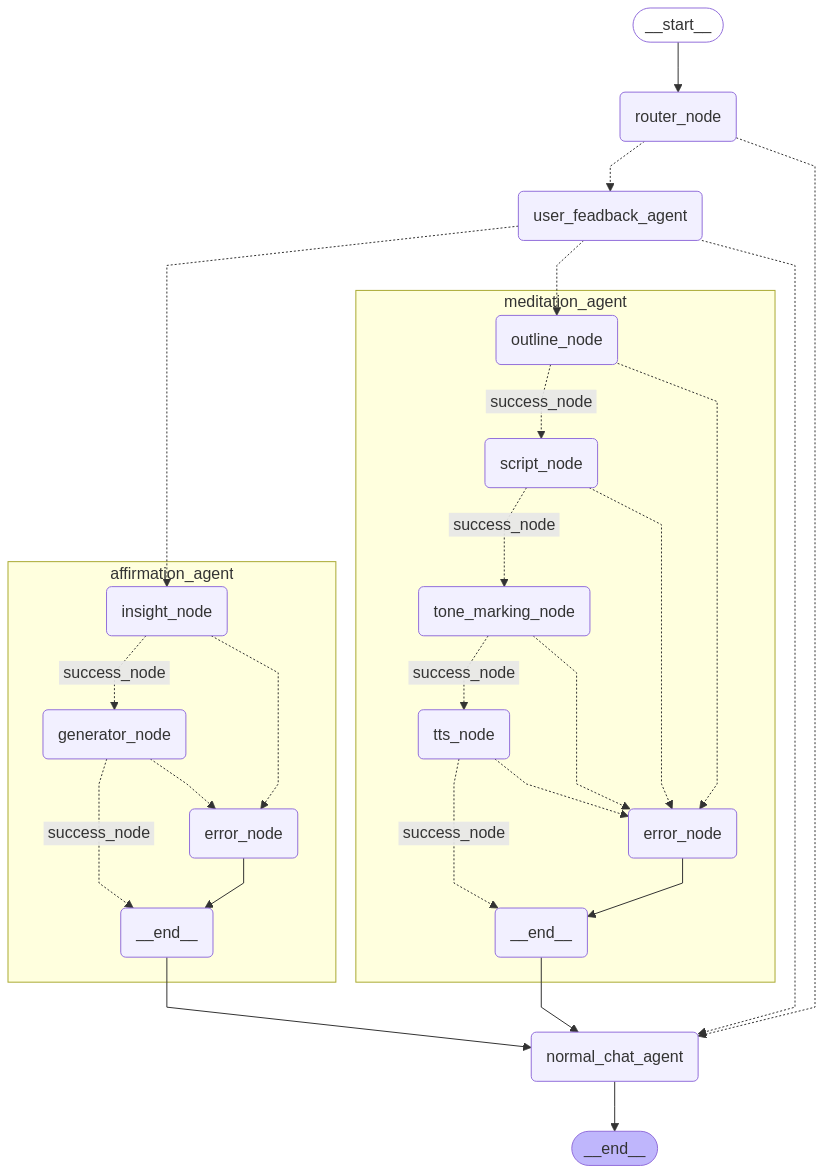

In [12]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(main_dialogue_graph.get_graph(xray=2).draw_mermaid_png()))


In [13]:
from uuid import uuid4
config = {"configurable": {"thread_id": str(uuid4())}}

In [14]:
inputs = {"messages": [HumanMessage(content="帮我生成一段静心冥想音频，让我不要担心考试")]}
async for stream_mode, chunk in main_dialogue_graph.astream(inputs, config=config, stream_mode=["updates", "messages"]):
    if stream_mode == "messages":
        if chunk[0].content:
            print(chunk[0].content, end="|", flush=True)
    elif stream_mode == "updates":
        if isinstance(chunk, dict) and "__interrupt__" in chunk:
            print(chunk["__interrupt__"], end="|", flush=True)
   

---routing---
---user_feadback---
(Interrupt(value={'question': '是否打开冥想音频？', 'options': ['yes', 'no'], 'default': 'no'}, resumable=True, ns=['user_feadback_agent:2bbabbf7-4b9b-0158-3829-4a0d585abcf9']),)|

In [15]:
async for stream_mode, chunk in main_dialogue_graph.astream(Command(resume="yes"), config=config, stream_mode=["updates", "messages"]):
    if stream_mode == "messages":
        # if chunk[0].__class__.__name__ == "AIMessageChunk" and chunk[0].content:
        #     print(chunk[0].content, end="|", flush=True)
        print("======", stream_mode, "======")
        print(chunk)
        print("\n")
    elif stream_mode == "updates":
        # if isinstance(chunk, dict) and "__interrupt__" in chunk:
        #     print(chunk["__interrupt__"], end="|", flush=True)
        print("======", stream_mode, "======")
        print(chunk)
        print("\n")

---user_feadback---
====== updates ======
{'user_feadback_agent': None}


====== messages ======
(AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_07e1ed1104744163b42834', 'function': {'arguments': '{"user', 'name': 'MeditationOutline'}, 'type': 'function'}]}, response_metadata={}, id='run-3dc391f2-ddd4-4094-bdf8-06b4eccd656d', tool_calls=[{'name': 'MeditationOutline', 'args': {}, 'id': 'call_07e1ed1104744163b42834', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'MeditationOutline', 'args': '{"user', 'id': 'call_07e1ed1104744163b42834', 'index': 0, 'type': 'tool_call_chunk'}]), {'thread_id': '52034878-4075-4dea-800a-4db3fac9dfcb', 'langgraph_step': 1, 'langgraph_node': 'outline_node', 'langgraph_triggers': ('branch:to:outline_node',), 'langgraph_path': ('__pregel_pull', 'outline_node'), 'langgraph_checkpoint_ns': 'meditation_agent:5b7de9cd-82f0-193f-4c7f-3f5389916a8e|outline_node:b5f6a033-e8db-7f01-ac1f-ba17332cafd6', 'checkpoint_ns': 'meditatio

Generating audio segments:   0%|          | 0/12 [00:00<?, ?it/s]2025-05-08 14:34:31,503 INFO synthesis text 让我们一起开始一段平静心灵的旅程,先深深地吸一口气[breath],慢慢地呼出[breath]。
2025-05-08 14:34:37,408 INFO yield speech len 9.68, rtf 0.6100068653910613
Generating audio segments:   8%|▊         | 1/12 [00:07<01:18,  7.12s/it]2025-05-08 14:34:38,547 INFO synthesis text 感受每一次呼吸,让紧张随气流[sigh]消散。
2025-05-08 14:34:45,387 INFO yield speech len 7.52, rtf 0.9095576215297618
Generating audio segments:  17%|█▋        | 2/12 [00:15<01:16,  7.62s/it]2025-05-08 14:34:46,530 INFO synthesis text 现在,将注意力集中在呼吸上,感受空气进入鼻孔,充满肺部,再缓缓流出[breath]。
2025-05-08 14:34:55,487 INFO yield speech len 13.48, rtf 0.6644104107197385
Generating audio segments:  25%|██▌       | 3/12 [00:25<01:18,  8.75s/it]2025-05-08 14:34:56,624 INFO synthesis text 想象每一次呼吸都带来清新的氧气,带走你的担忧。
2025-05-08 14:35:03,905 INFO yield speech len 7.04, rtf 1.034312898462469
Generating audio segments:  33%|███▎      | 4/12 [00:33<01:08,  8.62s/it]2025-05-08 14:35:05,047 INF

Combining audio segments with background music...
Saving final audio to /root/autodl-tmp/I-AM/project/backend/static/audio/7e5b2526-63d7-413e-b29d-8f2837d4c521_20250508143430.wav
Audio generation completed!
====== messages ======
(HumanMessage(content='帮我生成一段静心冥想音频，让我不要担心考试', additional_kwargs={}, response_metadata={}, id='3e3d2732-74d3-4bdc-833a-31a1b70708dc'), {'thread_id': '52034878-4075-4dea-800a-4db3fac9dfcb', 'langgraph_step': 3, 'langgraph_node': 'meditation_agent', 'langgraph_triggers': ('branch:to:meditation_agent',), 'langgraph_path': ('__pregel_pull', 'meditation_agent'), 'langgraph_checkpoint_ns': 'meditation_agent:5b7de9cd-82f0-193f-4c7f-3f5389916a8e'})


====== updates ======
{'meditation_agent': {'messages': [HumanMessage(content='帮我生成一段静心冥想音频，让我不要担心考试', additional_kwargs={}, response_metadata={}, id='3e3d2732-74d3-4bdc-833a-31a1b70708dc')], 'route': 'meditation', 'data': {'audio_url': '/audio/7e5b2526-63d7-413e-b29d-8f2837d4c521_20250508143430.wav'}, 'log': ['冥想音频生成中']}

In [16]:
chunk["normal_chat_agent"]

{'route': 'normal_chat',
 'messages': [AIMessage(content='听起来你现在正处在一种比较紧张的状态中，考试的压力让你感到有些焦虑。在这种情况下，确实适合进行一次冥想来帮助你放松心情，更好地准备即将到来的考试。我现在可以帮你联系我们的冥想智能体，它会为你定制一段冥想音频，帮助你减轻焦虑，集中注意力。\n\n要不我们现在就开始这个过程？我会将你的需求转交给冥想智能体，并确保他们为你准备最适合你的冥想音频。你觉得这样可以吗？\n\n如果你同意的话，请告诉我，我们可以开始了。', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'qwen2.5-14b-instruct'}, id='run-a4ec1017-382c-4539-ade0-e112623d7d00')],
 'data': {'audio_url': '/audio/7e5b2526-63d7-413e-b29d-8f2837d4c521_20250508143430.wav'},
 'log': '常规对话已生成'}

In [17]:
# import logging

# # 列出所有当前的 loggers
# for name, logger in logging.root.manager.loggerDict.items():
#     print(f"Logger name: {name}")
#     if isinstance(logger, logging.Logger):
#         print(f"  Level: {logger.level}")
#         print(f"  Handlers: {logger.handlers}")
#         print(f"  Parent: {logger.parent}")
#     print("---")

# # 然后根据发现的 logger 名称设置级别
# # 例如，如果发现是 'api_client' 在输出这些日志：
# # logging.getLogger('api_client').setLevel(logging.WARNING)

## 对话存储

In [18]:
# conversation_json = {
#     "messages": []
# }

# for d in chunk['messages']:
#     if type(d).__name__ == 'HumanMessage':
#         item = {"role": "user", "content": d.content}
#     elif type(d).__name__ == 'AIMessage':
#         item = {"role": "assistant", "content": d.content}
#     else:
#         continue
#     conversation_json['messages'].append(item)


In [19]:
# import json

# with open('conversations_data/meditation.json', 'w', encoding='utf-8') as f:
#     json.dump(conversation_json, f, indent=2, ensure_ascii=False)